In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

데이터 불러오기

In [2]:
data_path= "data"
normal_files = glob.glob(data_path+'/normal/'+'*.csv')
anormal_drift_files = glob.glob(data_path+'/anormal_drift/'+'*.csv')
anormal_erratic_files = glob.glob(data_path+'/anormal_erratic/'+'*.csv')
anormal_hardover_files = glob.glob(data_path+'/anormal_hardover/'+'*.csv')
anormal_spike_files = glob.glob(data_path+'/anormal_spike/'+'*.csv')
anormal_stuck_files = glob.glob(data_path+'/anormal_stuck/'+'*.csv')

In [3]:
#print(normal_files)

In [4]:
def dataReader(path_names):
    data_n = pd.DataFrame() #판다스의 데이터프레임 형태로 프레임 생성
    for i in path_names:
        low_data = pd.read_csv(i)# 판다스 형태로 읽음, 한csv파일씩 읽기 떄문에 다음 라인에서 하나로 합침
        data_n = pd.concat([data_n,low_data],ignore_index=True)
    return data_n

In [5]:
normal_datas = dataReader(normal_files)
drift_datas = dataReader(anormal_drift_files)
erratic_datas = dataReader(anormal_erratic_files)
hardover_datas = dataReader(anormal_hardover_files)
spike_datas = dataReader(anormal_spike_files)
stuck_datas = dataReader(anormal_stuck_files)

data shape 변경

In [6]:
#LSTM, LSTM-AE
def X_to_XyLSTM_shape(X,ntime_in,ntime_out): #X변형할 시계열 데이터 n_time_in 만큼 하나의 input으로 봄, ntime_out만큼 뒤에꺼를 예측
    nsample = len(X) - ntime_in -ntime_out + 1
    X_ntime = [0 for _ in range(nsample)]
    for i in range(nsample):
        X_ntime[i] = X[i:i+ntime_in]
    X_train = np.reshape(X_ntime,(nsample,ntime_in,1)) #2차원 배열을 3차원 배열으로
    print('X',X_train.shape)
    y_nfuture = [0 for _ in range(nsample)]
    for i in range(nsample):
        y_nfuture[i] = X[i+ntime_in:i+ntime_in+ntime_out]
    y_train = np.array(y_nfuture)
    print('y',y_train.shape)
    return X_train,y_train

In [7]:
n_time_in = 10 # 10개의 데이터 입력으로 받음
ntime_out = 1 # 다음 한개의 데이터 목표값

X_LSTM_train, y_LSTM_train = X_to_XyLSTM_shape(normal_datas['value'],n_time_in,ntime_out)

X (4031990, 10, 1)
y (4031990, 1)


In [8]:
#AE
def X_to_XyAE_shape(X,ntime_out): #X변형할 시계열 데이터, ntime_out만큼 뒤에꺼를 예측
    nsample = len(X) - ntime_out
    X_train = np.array(X[:nsample])
    y_train = np.array(X[ntime_out:len(X)])
    print('X',X_train.shape)
    print('y',y_train.shape)
    return X_train,y_train

In [9]:
X_AE_train, y_AE_train = X_to_XyAE_shape(normal_datas['value'],1)

X (4031999,)
y (4031999,)


모델 생성

In [10]:
from tensorflow.python.keras.layers import InputLayer, Dense, LSTM
from tensorflow.python.keras.models import Sequential

#LSTM_AE 모델
LSTM_AE_model = Sequential()

LSTM_AE_model.add(LSTM(128, input_shape=(n_time_in, 1)))
LSTM_AE_model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
LSTM_AE_model.add(Dense(32, activation='relu',kernel_initializer='random_uniform'))
LSTM_AE_model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
LSTM_AE_model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
LSTM_AE_model.add(Dense(ntime_out))

LSTM_AE_model.compile(loss="mean_squared_error",optimizer='adam')

#LSTM 모델
LSTM_model = Sequential()

LSTM_model.add(LSTM(128, input_shape=(n_time_in, 1)))
LSTM_model.add(Dense(ntime_out))

LSTM_model.compile(loss="mean_squared_error",optimizer='adam')

#AE 모델
"""
input_dim = 1  # 시계열 데이터의 차원
seq_length = 10  # 시계열 데이터의 길이
AE_model = Sequential()

AE_model.add(InputLayer(input_shape=(1,input_dim)))
AE_model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(32, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(input_dim,activation='linear'))

AE_model.compile(loss="mean_squared_error",optimizer='adam')
"""

AE_model = Sequential()

AE_model.add(InputLayer(input_shape=(1,1)))
AE_model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(32, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
AE_model.add(Dense(ntime_out,activation='linear'))

AE_model.compile(loss="mean_squared_error",optimizer='adam')

학습

In [11]:
LSTM_AE_model.fit(X_LSTM_train, y_LSTM_train, epochs=1, batch_size=100, verbose=0)

In [12]:
LSTM_model.fit(X_LSTM_train,y_LSTM_train, epochs=1, batch_size=100, verbose=0)

In [13]:
AE_model.fit(X_AE_train,y_AE_train, epochs=1, batch_size=100, verbose=0)

Test

In [14]:
anormal_list = [drift_datas,erratic_datas,hardover_datas,spike_datas,stuck_datas]

anormal_dictionary = {
    "drift":{
        "name" : "drift_datas",
        "pandas" : drift_datas
    }
    ,"erratic":{
        "name" : "erratic_datas",
        "pandas" : erratic_datas
    }
    ,"hardover":{
        "name" : "hardover_datas",
        "pandas" : hardover_datas
    }
    ,"spike":{
        "name" : "spike_datas",
        "pandas" : spike_datas
    }
    ,"stuck":{
        "name" : "stuck_datas",
        "pandas" : stuck_datas
    }
}

In [15]:
def MSE(target,predict):
    return (1.0/2.0)*(target-predict)**2

In [16]:
def error_matrix(perdict_error,real_error,threshold):
    predict_size = len(perdict_error)
    #오차행렬 초기화
    tp = 0
    fp = 0
    tn = 0
    fn = 0 
    Accuracy = np.nan
    Recall = np.nan
    Percision = np.nan
    Specificity = np.nan
    for i in range(predict_size):
        modelP = 0
        modelN = 0
        trueP = 0
        trueN = 0
        # 모델에 대한 P,N
        if(perdict_error[i] > threshold):
            modelP = 1
        else:
            modelN = 1
        #실제값에 대한 P,N
        if(real_error[i] == 1):
            trueP = 1
        else:
            trueN = 1
        #오차 행렬 업데이트
        if(modelP==1 and trueP == 1):
            tp += 1
        elif(modelP == 1 and trueN == 1):
            fp += 1
        elif(modelN == 1 and trueN == 1):
            tn += 1
        elif(modelN == 1 and trueP == 1):
            fn += 1
    if(tp+tn+fp+fn != 0):
        Accuracy = float(tp+tn)/float(tp+tn+fp+fn) # 전체 예측 중 맞게 예측
    if(tp+fn != 0):
        Recall = float(tp)/float(tp+fn) # 실제 오류 중 오류라고 예측한 것
    if(tp+fp != 0):
        Percision = float(tp)/float(tp+fp) # 오류라고 예측한 것 중 실제 오류
    if(fp+tn != 0):
        Specificity = float(tn)/float(fp+tn) # 오류가 아니라고 예측 한 것 중 정말 오류가 아닌 것
    
    return Accuracy,Recall,Percision,Specificity

In [49]:
def evaluation(y_test,y_predict,test_size,test_data,threshold):
    perdict_error =MSE(y_test[:test_size-ntime_out],y_predict[ntime_out:test_size])
    perdict_error = perdict_error.reshape(len(perdict_error))
    perdict_error.shape

    real_error = np.array(test_data['error'][n_time_in:test_size+n_time_in-ntime_out])
    real_error.shape

    print(error_matrix(perdict_error,real_error,threshold))

In [52]:
def draw_graph(anormal_dictionary,n_time_in,ntime_out):
    for anormal_data in anormal_dictionary:
        print("++++++++++++++++++++++++++++++++++++")
        print(anormal_dictionary[anormal_data]['name'])

        test_data = anormal_dictionary[anormal_data]['pandas']

        print("------------LSTM-AE---------------")
        X_LSTMAE_test,y_LSTMAE_test =X_to_XyLSTM_shape(test_data['value'][:10000],n_time_in,ntime_out)
        y_LSTMAE_predict = LSTM_AE_model.predict(X_LSTMAE_test,verbose=0)
        test_size = len(y_LSTMAE_predict)
        #print(test_data)
        """
        plt.plot(y_LSTMAE_predict[ntime_out:test_size])
        plt.show()
        plt.plot(y_LSTMAE_test[:test_size-ntime_out])
        plt.show()
        plt.close()
        """
        plt.plot(MSE(y_LSTMAE_test[:test_size-ntime_out],y_LSTMAE_predict[ntime_out:test_size])) #y_test는 실제 값 ,y_predict는 예측 값 예측값은 ntime_out 만큼 밀려서 나옴
        #plt.plot(y_LSTMAE_test[:test_size-ntime_out]-y_LSTMAE_predict[ntime_out:test_size])
        plt.plot(test_data['error'][n_time_in:test_size+n_time_in-ntime_out])
        #plt.plot(test_data['value'][n_time_in:test_size]) # test_data['value'][n_time_in:test_size] == y_test[:test_size-ntime_out] 실제 값
        plt.show()
        plt.close()
        threshold = 0.9
        evaluation(y_LSTMAE_test,y_LSTMAE_predict,test_size,test_data,threshold)

        print("--------------LSTM-----------------")
        X_LSTM_test,y_LSTM_test = X_to_XyLSTM_shape(test_data['value'][:10000],n_time_in,ntime_out)
        y_LSTM_predict = LSTM_model.predict(X_LSTM_test,verbose=0)
        test_size = len(y_LSTM_predict)
        plt.plot(MSE(y_LSTM_test[:test_size-ntime_out],y_LSTM_predict[ntime_out:test_size])) #y_test는 실제 값 ,y_predict는 예측 값 예측값은 ntime_out 만큼 밀려서 나옴
        #plt.plot(y_LSTMAE_test[:test_size-ntime_out]-y_LSTMAE_predict[ntime_out:test_size])
        plt.plot(test_data['error'][n_time_in:test_size+n_time_in-ntime_out])
        #plt.plot(test_data['value'][n_time_in:test_size]) # test_data['value'][n_time_in:test_size] == y_test[:test_size-ntime_out] 실제 값
        plt.show()
        plt.close()
        threshold = 0.9
        evaluation(y_LSTM_test,y_LSTM_predict,test_size,test_data,threshold)

        print("----------------AE------------------")
        X_AE_test,y_AE_test = X_to_XyAE_shape(test_data['value'][:10000],ntime_out)
        y_AE_predict = AE_model.predict(X_AE_test,verbose=0)
        y_AE_predict = y_AE_predict.reshape(len(y_AE_predict))
        test_size = len(y_AE_predict)
        plt.plot(MSE(y_AE_test[:test_size-ntime_out],y_AE_predict[ntime_out:test_size])) #y_test는 실제 값 ,y_predict는 예측 값 예측값은 ntime_out 만큼 밀려서 나옴
        #plt.plot(y_LSTMAE_test[:test_size-ntime_out]-y_LSTMAE_predict[ntime_out:test_size])
        plt.plot(test_data['error'][n_time_in:test_size+n_time_in-ntime_out])
        #plt.plot(test_data['value'][n_time_in:test_size]) # test_data['value'][n_time_in:test_size] == y_test[:test_size-ntime_out] 실제 값
        plt.show()
        plt.close()
        threshold = 0.9
        evaluation(y_AE_test,y_AE_predict,test_size,test_data,threshold)
        

++++++++++++++++++++++++++++++++++++
drift_datas
------------LSTM-AE---------------
X (9990, 10, 1)
y (9990, 1)


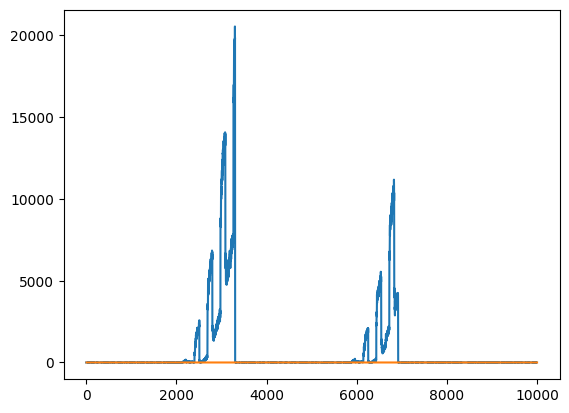

--------------LSTM-----------------
X (9990, 10, 1)
y (9990, 1)


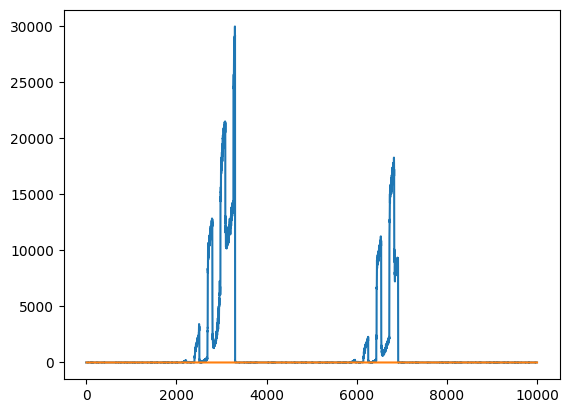

----------------AE------------------
X (9999,)
y (9999,)


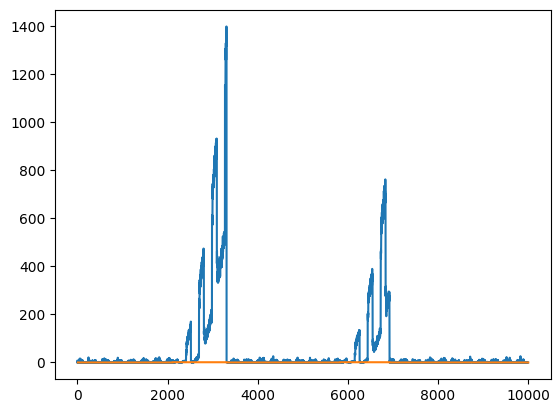

ValueError: operands could not be broadcast together with shapes (9990,1) (9989,1) 

In [53]:
draw_graph(anormal_dictionary,n_time_in,ntime_out)